# Sentiment Analysis with BERT

## Importing libraries

In [ ]:
!pip install transformers

In [102]:
from pyspark.sql import SparkSession

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report

## Data Sampling

In [92]:
spark = SparkSession.builder.appName("Data Sampling for BERT model").getOrCreate()
reviewsDF = spark.read.json("data/yelp_academic_dataset_review.json")
reviewsDF.createOrReplaceTempView("review")

filtered_df = spark.sql("""
                        SELECT text, stars
                        FROM review
                        """)

filtered_df.show()
sampled_df = filtered_df.sample(withReplacement = False, fraction = 10000/filtered_df.count(), seed = 4)

pandasDF = sampled_df.toPandas()
pandasDF.head()

spark.stop()

25/05/05 12:31:16 ERROR Inbox: Ignoring error=========>           (32 + 8) / 40]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apach

+--------------------+-----+
|                text|stars|
+--------------------+-----+
|If you decide to ...|  3.0|
|I've taken a lot ...|  5.0|
|Family diner. Had...|  3.0|
|Wow!  Yummy, diff...|  5.0|
|Cute interior and...|  4.0|
|I am a long term ...|  1.0|
|Loved this tour! ...|  5.0|
|Amazingly amazing...|  5.0|
|This easter inste...|  3.0|
|Had a party of 6 ...|  3.0|
|My experience wit...|  5.0|
|Locals recommende...|  4.0|
|Love going here f...|  4.0|
|Good food--loved ...|  4.0|
|The bun makes the...|  4.0|
|Great place for b...|  5.0|
|Tremendous servic...|  5.0|
|The hubby and I h...|  4.0|
|I go to blow bar ...|  5.0|
|My absolute favor...|  5.0|
+--------------------+-----+
only showing top 20 rows



25/05/05 12:31:26 ERROR Inbox: Ignoring error                      (0 + 8) / 40]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apach

## BERT Tokenization

In [93]:
# Separator token which lets BERT know the end of a sentence
print(tokenizer.sep_token, tokenizer.sep_token_id)

# Classification token which lets BERT know the beginning of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id)

# Padding token which is the filler for reviews that do not reach the max length to make inputs the same length
print(tokenizer.pad_token, tokenizer.pad_token_id)

# Unknown token to replace words that are not in BERT's vocabulary
print(tokenizer.unk_token, tokenizer.unk_token_id)


[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


/var/folders/5m/n3lmdh1d5bl0t6d_1p3n_2wh0000gn/T/ipykernel_23130/1760395435.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


<Axes: ylabel='Density'>

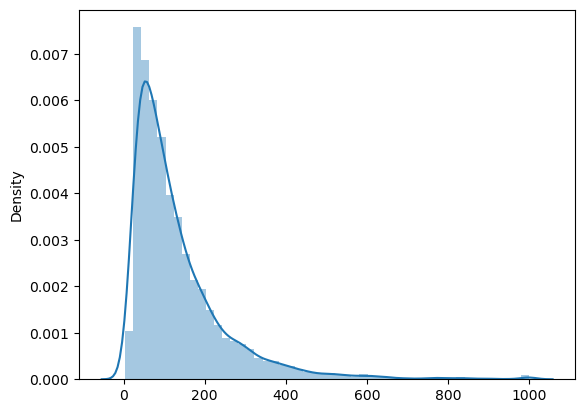

In [163]:
token_lens = []

for text in pandasDF.text:
    tokens = tokenizer.encode(text, max_length = 1000)
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)

Based on the distplot, we will pick a max_length of around 400 tokens.

In [172]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

texts = pandasDF['text'].tolist()
labels = pandasDF['stars'].tolist()

# List of token IDs representing the actual words in input
tokenizedId = []

# This tells BERT which parts it pay attention to by ignoring all the PAD(filler) tokens
tokenizedMask = []

# Encoding/tokenizing every review
for text in texts:
    encoded = tokenizer.encode_plus(
        text,
        max_length= 400,
        add_special_tokens= True,
        pad_to_max_length= True,
        return_attention_mask= True,
        return_tensors='pt'
    )
    
    tokenizedId.append(encoded['input_ids'])
    tokenizedMask.append(encoded['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [96]:
print(tokenizedId[1])
print(tokenizedMask[1])
print(labels[1])

tensor([[  101,  2034,  1997,  2035,  1010,  1045,  2228,  2023,  2453,  2022,
          2026,  2034,  6300, 14277,  3319,  2055,  1000,  3435,  2833,  1012,
          1000,  2009,  1005,  1055,  2025,  1037,  6907,  1045,  2412,  4521,
          4983,  1045,  1005,  1049,  3140,  2000,  2006,  1037,  2346,  4440,
          1012,  2174,  1010,  1045,  2572,  2013,  6901,  1010,  6396,  1010,
          1998,  2572,  1037,  7975,  1011,  4344,  9530,  3630, 23491,  3126,
          1010,  2061,  1045,  2787,  2000,  2507,  2023,  2173,  1037,  3382,
          1012,  5678,  1010,  2009,  2001,  2006,  1037,  2346,  4440,  1997,
         11901,  1012,  2057,  2018,  2042,  2012,  1996,  3509,  2035,  2154,
          1998,  2020,  8576,  2067,  2188,  2000,  2430,  9925,  1012,  1996,
          2326,  2003,  6429,   999,  1045,  2031,  2196,  2464,  3435,  1011,
          2833,  3667,  2040,  2202,  2061,  2172,  6620,  1999,  2037,  5841,
          1012,  2122,  2111,  2020,  5948,  1996, 2

/Users/zaftyguy/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


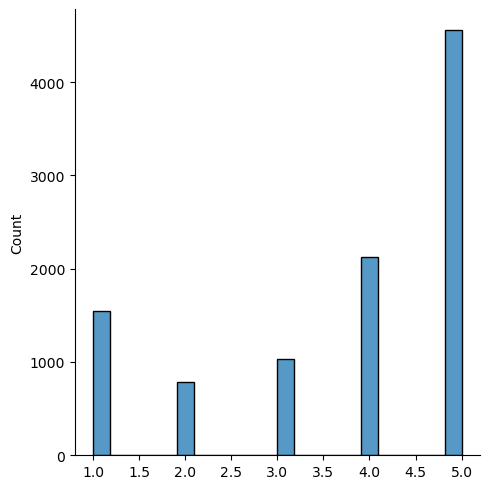

In [97]:
sns.displot(labels)

In [173]:
# Turning lists into tensor
tokenizedId = torch.cat(tokenizedId, dim=0)
tokenizedMask = torch.cat(tokenizedMask, dim=0)

labels = [label - 1 for label in labels]
labels = torch.tensor(labels)

In [174]:
labels

tensor([0., 4., 0.,  ..., 0., 3., 4.])

In [175]:
print(tokenizedId.shape)
print(tokenizedMask.shape)
print(labels.shape)

torch.Size([10056, 400])
torch.Size([10056, 400])
torch.Size([10056])


## Creating Data Loader

In [142]:
BATCH_SIZE = 32
MAX_LENGTH = 400
EPOCHS = 4

In [176]:
dataset = TensorDataset(tokenizedId, tokenizedMask, labels)

train, test = train_test_split(dataset, test_size= 0.2, random_state = 3)
val, test = train_test_split(test, test_size= 0.5, random_state = 3)

In [177]:
train, val, test = pd.DataFrame(train), pd.DataFrame(val), pd.DataFrame(test)
train.shape, val.shape, test.shape

((8044, 3), (1006, 3), (1006, 3))

In [185]:
trainDataLoad = DataLoader(train, sampler= RandomSampler(train), batch_size= BATCH_SIZE)
valDataLoad = DataLoader(val, sampler= RandomSampler(val), batch_size= BATCH_SIZE)
testDataLoad = DataLoader(test, sampler= RandomSampler(test), batch_size= BATCH_SIZE)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels= 5, output_attentions= False,
                                                     output_hidden_states = False)

# Updates model's weights
optimizer = AdamW(model.parameters(), lr= 2e-5, eps= 1e-8)

trainingSteps = len(trainDataLoad) * EPOCHS

# Makes sure that learning rate doesn't overshoot by decreasing learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= 0,
                                           num_training_steps= trainingSteps)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model.to(device)

for i in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in trainDataLoad:
        inputId = batch[0].to(device)
        attenMask = batch[1].to(device)
        batchLabel = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids= inputId, attention_mask= attenMask, labels= batchLabel)

        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyError: 4293